<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2025/blob/main/notebooks/es_29.5/AI_2025_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelli generativi basati su VAE

scopo: familiarizzare con la progettazione e l'uso di archietture generative basate su VAE
DL tool: pytorch

### tasks ###

1.   implementazione di una beta-VAE (eg una VAE con un iperparametro che controlla il peso relativo del termine di divergenza rispetto al termine di ricostruzione nella loss per la generazione di immagini realistiche


Referenze:

*   [VAE](https://arxiv.org/abs/1312.6114) e [beta-VAE](https://openreview.net/forum?id=Sy2fzU9gl)



**Datasets:**

*  [fashion-MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST)



In [ ]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.3.0+cu121
0.18.0+cu121


il dataset FashionMNIST è costituito da immagini di icone di oggetti di viestiario corrispondenti a 60k immagini per il training e 10k immagini per il test.

Ogni immagine ha dimensione $(28,28)$ pixel, con un canale di intensità (scala di grigi) a 8 bit (valori di intensità di ogni pixel $\in [0,256]$).

È disponibile in varie librerie per il ML (scikit-learn, torch, tensorflow, librerie esterne...). Prendendo il dataset già disponibile in pytorch possiamo sfruttare il vantaggio di di avere conversioni automatiche in tensori torch e normalizzazioni. Leggendo il dataset da un input esterno, come per esempio fatto nell'esercitazione su PCA prendendolo da openm, in formato di ndarray numpy, dovremo convertire noi i vettori in tensori torch e normalizzarli, ma risulterà più chiaro come usare in generale datset esterni. in questo hands-on utilizzeremo questo secondo approccio.

In [ ]:
# lettura del dataset Fashion-MNIST da openml usando la libreria sklearn
# label:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

from sklearn.datasets import fetch_openml

images, labels = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) # converte le label in int

print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


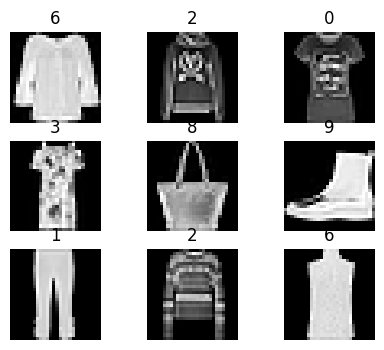

In [ ]:
# grafichiamo 9 immagini random
figure = plt.figure(figsize=(5, 4))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(images))
    img, label = images[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()

In [ ]:
# splitting del campione in training e test (80:20)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=12345)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(56000, 784)
(56000,)
(14000, 784)
(14000,)


In [ ]:
# le immagini Fashion-MNIST sono immagini in scala di grigio a 8 bit, ogni pixel assume valore [0,255], quindi per
# normalizzare in [0,1] basta solo divider tutte le immagini per 255

X_train_norm = X_train / 255.
X_test_norm  = X_test / 255.

In [ ]:
# per questa esercitazione è consigliabile usare una GPU
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# conversione in tensori torch dei vettori numpy

X_train_pt = torch.Tensor(X_train_norm).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_test_pt = torch.Tensor(X_test_norm).float()
Y_test_pt = torch.Tensor(Y_test).int()

# reshape the tensori da (n,784) a (n,1,28,28) come richiesto da conv layer in pytorch

X_train_pt = X_train_pt.view((X_train_pt.shape[0],1,28,28))
X_test_pt = X_test_pt.view((X_test_pt.shape[0],1,28,28))

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([56000, 1, 28, 28])
torch.Size([56000])
torch.Size([14000, 1, 28, 28])
torch.Size([14000])


In [ ]:
# dataset e dataloaders

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=1, drop_last=True)

### Definzione del modello di rete neurale.

Architettura: VAE convoluzionale con encoder costituito da 2 layer convoluzionali 2D con kernel_size 4 e stride 2 (per comprimere le rappresentazioni), decoder costituito da ConvTranspose2D. Lo spazio latente z è costituito da un layer denso. Usiamo attivazioni ReLu nella parte convoluzionale e sigmoide nell'output in modo da allenare il modello con BCE come reconstruction loss + KL-divergence come regolarizzatore

In [ ]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

       ######

    def forward(self, x):

        ########

        return x_mu, x_logvar

In [ ]:
# Convolutional Decoder Model

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [ ]:
# Full VAE/AE Model

